In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Windowed Data Preparation

In [31]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Function that creates windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Ensures windows are of equal size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flattens the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffles the dataset
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    
    # Batches the data into sets of 32
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [32]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


### Model Definition

In [36]:
# Defines the layer
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

# Defines the model
model = tf.keras.models.Sequential([l0])

### Model Compilation & Fitting

In [39]:
# Compiles the model
model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(lr=1e-6, 
                                                momentum=0.9)
             )

# Fits the model
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
980/980 [==============================] - 4s 5ms/step - loss: 78.8746
Epoch 2/100
980/980 [==============================] - 1s 1ms/step - loss: 69.1036
Epoch 3/100
980/980 [==============================] - 2s 2ms/step - loss: 62.8429
Epoch 4/100
980/980 [==============================] - 2s 2ms/step - loss: 64.6617
Epoch 5/100
980/980 [==============================] - 2s 2ms/step - loss: 65.5730
Epoch 6/100
980/980 [==============================] - 2s 2ms/step - loss: 58.4930
Epoch 7/100
980/980 [==============================] - 2s 2ms/step - loss: 58.7187: 0s - los
Epoch 8/100
980/980 [==============================] - 2s 2ms/step - loss: 63.6699
Epoch 9/100
980/980 [==============================] - ETA: 0s - loss: 69.80 - 2s 2ms/step - loss: 69.1557
Epoch 10/100
980/980 [==============================] - 3s 3ms/step - loss: 67.4165
Epoch 11/100
980/980 [==============================] - 2s 2ms/step - loss: 66.8172
Epoch 12/100
980/980 [=============================

980/980 [==============================] - 2s 2ms/step - loss: 64.2897
Epoch 98/100
980/980 [==============================] - 2s 2ms/step - loss: 66.9449
Epoch 99/100
980/980 [==============================] - 1s 1ms/step - loss: 69.7379
Epoch 100/100
980/980 [==============================] - 1s 2ms/step - loss: 63.2344


In [40]:
# Prints the l0 weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-4.4555958e-02],
       [ 3.4348867e-03],
       [ 3.7142131e-02],
       [-1.6910059e-02],
       [ 1.6758148e-02],
       [-1.6647056e-02],
       [-1.3374278e-02],
       [-1.8546335e-02],
       [-3.6026336e-02],
       [-4.0636922e-04],
       [-2.2734767e-02],
       [-2.5790801e-02],
       [-5.0284173e-02],
       [ 4.2783972e-02],
       [-7.3190783e-03],
       [ 1.4110900e-02],
       [-7.0698489e-03],
       [ 1.4878851e-01],
       [ 2.4860546e-01],
       [ 4.7840056e-01]], dtype=float32), array([0.6543962], dtype=float32)]


In [42]:
forecast = []

for time in range(len(series) - window_size):
    prediction = model.predict(series[time:time + window_size][np.newaxis])
    forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

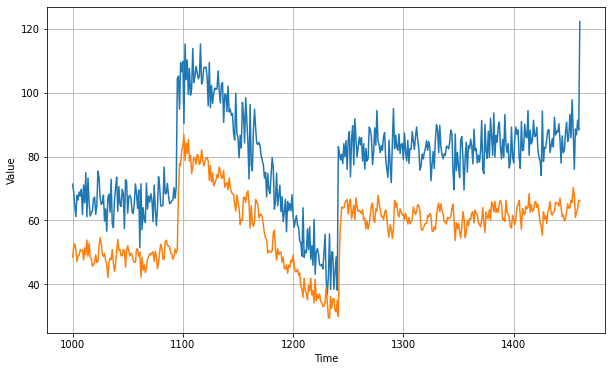

In [43]:
# Plots the t
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [44]:
# Calculates the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

20.518482